# What is the best place to open a new Mexican restaurant in New York

## Introduction:
The objective of this project is to analyze available data regarding New York City to determine the best neighborhood to open a Mexican Restaurant or any other Foreign Cuisine restaurant.

## Business Problem.
Nowadays, starting a new business is a very risky task and should be approached carefully. Having a market study is something mandatory to avoid a failure. That's the reason why we should use as many available tools to minimize the risk of starting any new business.

## Getting Ready
First let's prepare our environment loading everything we need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

# 1. Getting the dataset
First we will use the New York dataset containing all of the neighborhoods.
Let's download it and open it.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

print('Dataset loaded!')

Dataset loaded!


Now we need the data located in the Features Key as this will help us to search in the Foursquare API.

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Once we got the data we need, we should transform it into a pandas dataframe to make it easier to use.

In [6]:
#Now lets load the data into our empty dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Now lets take a glimpse at our dataframe

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


The next step is to use geopy to get the latitude and longitude of New york

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# 2. Setting the Foursquare API

Now lets prepare the foursquare api to get the info we need.

In [9]:
CLIENT_ID = 'O0MSU4FXDK3SY0TORFYIMHJ4SFR5EXXR32XBT50SEI5IEJ33'
CLIENT_SECRET = 'VZYNDF0MFCZHQBBUY55LCBSGFGQNPHHC5UEB3EA10EDXP20G'
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: O0MSU4FXDK3SY0TORFYIMHJ4SFR5EXXR32XBT50SEI5IEJ33
CLIENT_SECRET:VZYNDF0MFCZHQBBUY55LCBSGFGQNPHHC5UEB3EA10EDXP20G


Let's define the function to get the venues:

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now Let's use it

In [11]:
radius = 500
LIMIT = 100
new_york_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

Let's check the size of our new dataframe

In [12]:
print(new_york_venues.shape)
new_york_venues.head()
print('There are {} uniques categories.'.format(len(new_york_venues['Venue Category'].unique())))

(10072, 7)
There are 430 uniques categories.


Now let's analyze each neighborhood

In [13]:
# one hot encoding
newyork_onehot = pd.get_dummies(new_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = new_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bangladeshi Restaurant,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaur

Let's see its shape

In [14]:
newyork_onehot.shape

(10072, 430)

The next step is to group by neighborhoods.

In [15]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bangladeshi Restaurant,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaur

Now we create the definition to sort the venues in descending order

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create a new dataframe to display the top 10 venues for each neighborhood

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Chinese Restaurant,Deli / Bodega,Discount Store,Electronics Store,Fast Food Restaurant,Martial Arts School,Bakery,Pharmacy
1,Annadale,Pizza Place,Restaurant,Train Station,Diner,Pub,American Restaurant,Bar,Dance Studio,Exhibit,Event Space
2,Arden Heights,Pharmacy,Lawyer,Coffee Shop,Bus Stop,Pizza Place,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
3,Arlington,Bus Stop,Deli / Bodega,Intersection,Coffee Shop,Boat or Ferry,Women's Store,Fish Market,Factory,Falafel Restaurant,Farm
4,Arrochar,Bus Stop,Pizza Place,Italian Restaurant,Deli / Bodega,Hotel,Middle Eastern Restaurant,Bagel Shop,Outdoors & Recreation,Liquor Store,Sandwich Place


# 3. Selecting our Clustering tool
For this project I will use K-Means as it is a simple yet effective method for clustering and It will provide us with the results we need.
First let's calculate a proper number of clusters using the elbow method.

In [18]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
from scipy.spatial.distance import cdist

Let's try to find the best number between 1 and 20.

In [19]:
newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(newyork_grouped_clustering) 
    kmeanModel.fit(newyork_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(newyork_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / newyork_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(newyork_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / newyork_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_

In [20]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

1 : 0.26877028314133916
2 : 0.26214414453550333
3 : 0.25873756551667587
4 : 0.25480341031516046
5 : 0.2496730345788462
6 : 0.2497267235101822
7 : 0.24326378957927147
8 : 0.23980270015636188
9 : 0.23685177862180007
10 : 0.23551747184246027
11 : 0.23268889991053912
12 : 0.23054183293087832
13 : 0.2283212604258846
14 : 0.22801334575868948
15 : 0.22471326743522296
16 : 0.22321586204597094
17 : 0.2212271093155399
18 : 0.21974308495532102
19 : 0.21710070186156308


Let´s plot the values we got for Distortion

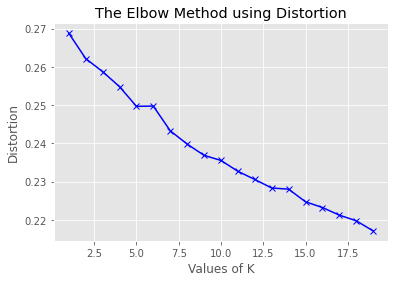

In [23]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [24]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))

1 : 28.46069790690716
2 : 26.527628368703297
3 : 25.46083439722778
4 : 24.4654627537685
5 : 23.851413267889146
6 : 23.098389577919626
7 : 22.04398027616346
8 : 21.235131918223992
9 : 20.814248496409252
10 : 20.490278440662223
11 : 19.857422073955732
12 : 19.200763316397417
13 : 19.03442312270521
14 : 18.803352647916526
15 : 18.445572022426695
16 : 18.307365546993186
17 : 17.62203429308816
18 : 17.598586763787427
19 : 17.289798822502213


Not let's plot the values for Inertia

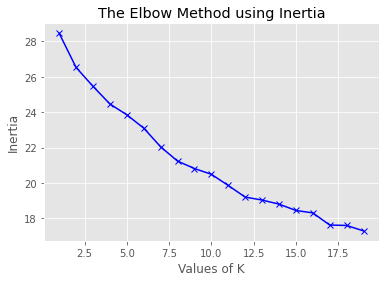

In [25]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Having these results we can assume that is safe to use a number of clusters of 5

In [26]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

Let's merge the date

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,2.0,Pharmacy,Sandwich Place,Pizza Place,Deli / Bodega,Gas Station,Dessert Shop,Donut Shop,Ice Cream Shop,Laundromat,Fast Food Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,2.0,Baseball Field,Basketball Court,Deli / Bodega,Park,Post Office,Restaurant,Bus Station,Salon / Barbershop,Fast Food Restaurant,Discount Store
2,Bronx,Eastchester,40.887556,-73.827806,2.0,Bus Station,Caribbean Restaurant,Bus Stop,Deli / Bodega,Diner,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Donut Shop,Platform
3,Bronx,Fieldston,40.895437,-73.905643,2.0,River,Bus Station,Medical Supply Store,Plaza,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,2.0,Medical Supply Store,Bus Station,Park,Home Service,Gym,Bank,Plaza,Food Truck,Food & Drink Shop,Event Space


In [28]:
#We clean our dataframe
newyork_merged = newyork_merged.dropna()

Now Let's visualize the resulting clusters.

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4. Examining the Clusters
Let's examine our resultering clusters

## Cluster 1.

In [30]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,Beach,Trail,Monument / Landmark,Women's Store,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
179,Neponsit,Beach,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
204,South Beach,Deli / Bodega,Beach,Pier,Athletics & Sports,Women's Store,Fish Market,Factory,Falafel Restaurant,Farm,Farmers Market
302,Hammels,Beach,Dog Run,Shoe Store,Gym / Fitness Center,Fast Food Restaurant,Bus Stop,Diner,Bus Station,Food Truck,Deli / Bodega


## Cluster 2.

In [28]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
89,Ocean Hill,Deli / Bodega,Playground,Grocery Store,Fried Chicken Joint,Food,Coffee Shop,Metro Station,Bus Stop,Hardware Store,Check Cashing Service
150,Whitestone,Bubble Tea Shop,Boxing Gym,Deli / Bodega,Candy Store,Dance Studio,Israeli Restaurant,Fish Market,Eye Doctor,Factory,Falafel Restaurant
159,Briarwood,Deli / Bodega,Playground,Bus Station,Coffee Shop,Gym,Indian Restaurant,Convenience Store,Arts & Crafts Store,Eye Doctor,Factory
193,Brookville,Deli / Bodega,Women's Store,Fish Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
198,New Brighton,Bus Stop,Deli / Bodega,Park,Playground,Chinese Restaurant,Discount Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
202,Grymes Hill,Dog Run,Deli / Bodega,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
204,South Beach,Deli / Bodega,Beach,Pier,Athletics & Sports,Women's Store,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market
205,Port Richmond,Rental Car Location,Bus Stop,Pizza Place,Donut Shop,Bar,Deli / Bodega,Fountain,Eye Doctor,Factory,Falafel Restaurant
206,Mariner's Harbor,Italian Restaurant,Deli / Bodega,Supermarket,Athletics & Sports,Women's Store,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,Farm
217,Tottenville,Cosmetics Shop,Deli / Bodega,Italian Restaurant,Thrift / Vintage Store,Mexican Restaurant,Bus Stop,Farmers Market,Filipino Restaurant,Field,Fast Food Restaurant


## Cluster 3.

In [29]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Donut Shop,Gas Station,Sandwich Place,Laundromat,Ice Cream Shop,Pizza Place,Dessert Shop,Deli / Bodega,Falafel Restaurant
1,Co-op City,Bus Station,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Park,Baseball Field,Restaurant,Post Office,Discount Store,Grocery Store
2,Eastchester,Deli / Bodega,Caribbean Restaurant,Diner,Convenience Store,Fast Food Restaurant,Chinese Restaurant,Seafood Restaurant,Automotive Shop,Platform,Bowling Alley
4,Riverdale,Park,Plaza,Bank,Bus Station,Food Truck,Gym,Fish & Chips Shop,Factory,Falafel Restaurant,Farm
5,Kingsbridge,Pizza Place,Bar,Latin American Restaurant,Mexican Restaurant,Bakery,Sandwich Place,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Pharmacy
6,Marble Hill,Coffee Shop,Gym,Discount Store,Yoga Studio,Video Game Store,Tennis Stadium,Shopping Mall,Seafood Restaurant,Pharmacy,Sandwich Place
8,Norwood,Pizza Place,Park,Bank,Pharmacy,Burger Joint,Sandwich Place,Cafeteria,Spanish Restaurant,Caribbean Restaurant,Fast Food Restaurant
10,Baychester,Donut Shop,Fried Chicken Joint,Mexican Restaurant,Shopping Mall,Mattress Store,Bus Station,Fast Food Restaurant,Bank,Pet Store,Electronics Store
11,Pelham Parkway,Italian Restaurant,Frozen Yogurt Shop,Pizza Place,Deli / Bodega,Gas Station,Chinese Restaurant,Mexican Restaurant,Eye Doctor,Smoke Shop,Bank
13,Bedford Park,Diner,Chinese Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Pharmacy,Supermarket,Sandwich Place,Italian Restaurant,Grocery Store


## Cluster 4.

In [30]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,Plaza,River,Music Venue,Bus Station,Women's Store,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
7,Woodlawn,Deli / Bodega,Pub,Pizza Place,Playground,Bar,Food Truck,Rental Car Location,Grocery Store,Park,Trail
9,Williamsbridge,Nightclub,Caribbean Restaurant,Soup Place,Bar,Dance Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
12,City Island,Thrift / Vintage Store,Boat or Ferry,Seafood Restaurant,Jewelry Store,Bank,Baseball Field,Tapas Restaurant,Spanish Restaurant,Café,Smoke Shop
22,Port Morris,Furniture / Home Store,Storage Facility,Latin American Restaurant,Food Truck,Brewery,Spanish Restaurant,Grocery Store,Metro Station,Peruvian Restaurant,Donut Shop
24,Hunts Point,Pizza Place,Gourmet Shop,Grocery Store,BBQ Joint,Farmers Market,Mexican Restaurant,Bakery,Food,Bank,Café
28,Throgs Neck,Asian Restaurant,American Restaurant,Liquor Store,Mobile Phone Shop,Chinese Restaurant,Pizza Place,Bar,Deli / Bodega,Sports Bar,Coffee Shop
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Bank,Grocery Store,Donut Shop,Bar,Fish Market
39,Edgewater Park,Italian Restaurant,Deli / Bodega,Coffee Shop,Pizza Place,Ice Cream Shop,Park,Bar,Liquor Store,Bookstore,Donut Shop
46,Bay Ridge,Pizza Place,Italian Restaurant,Spa,Greek Restaurant,Bar,American Restaurant,Chinese Restaurant,Café,Pharmacy,Sushi Restaurant


## Cluster 5.

In [31]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Country Club,Sandwich Place,Athletics & Sports,Playground,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
182,Holliswood,Fried Chicken Joint,Donut Shop,Mobile Phone Shop,Grocery Store,Playground,Sandwich Place,Food Court,Food & Drink Shop,Eye Doctor,Factory
226,Graniteville,Grocery Store,Women's Store,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
303,Bayswater,Playground,Women's Store,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
305,Fox Hills,Sandwich Place,Cocktail Bar,Playground,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market


# 5. Conclusions
Now that we have seen every cluster I can determine that the best neighborhood to open a Mexican Restaurant would be somewhere in Cluster 3 or 4, for example: 

## --Longwood

In [48]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Longwood' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Longwood,Diner,Fast Food Restaurant,Sandwich Place,Tattoo Parlor,Latin American Restaurant,Grocery Store,Donut Shop,Deli / Bodega,Farmers Market,Fish & Chips Shop


## --Westchester Square

In [49]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Westchester Square' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Westchester Square,Donut Shop,Fast Food Restaurant,Pizza Place,Sandwich Place,Baseball Field,Pharmacy,Metro Station,Discount Store,Latin American Restaurant,Check Cashing Service


## --Concourse

In [50]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Concourse' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Concourse,Grocery Store,Chinese Restaurant,Fried Chicken Joint,Italian Restaurant,Bakery,Donut Shop,Convenience Store,Playground,Pizza Place,Pharmacy


## -- Throgs Neck

In [52]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Throgs Neck' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Throgs Neck,Asian Restaurant,American Restaurant,Liquor Store,Mobile Phone Shop,Chinese Restaurant,Pizza Place,Bar,Deli / Bodega,Sports Bar,Coffee Shop


## --Bay Ridge

In [53]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Bay Ridge' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Bay Ridge,Pizza Place,Italian Restaurant,Spa,Greek Restaurant,Bar,American Restaurant,Chinese Restaurant,Café,Pharmacy,Sushi Restaurant


## --Fort Hamilton

In [54]:
newyork_merged.loc[newyork_merged['Neighborhood'] == 'Fort Hamilton' ,newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
99,Fort Hamilton,Pizza Place,Chinese Restaurant,Gym / Fitness Center,Deli / Bodega,Sandwich Place,Italian Restaurant,Japanese Restaurant,Bank,Donut Shop,Steakhouse


All of these neighborhoods have plenty of foreign restaurants but doesn't have Mexican Food yet so It would be a novelty to open one in one of these neighborhoods.